In [1]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from math import ceil

import numpy as np

In [2]:
train = datasets.FashionMNIST('../data/FasionMNIST/train', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.FashionMNIST('../data/FasionMNIST/test', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

In [3]:
trainset = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

In [4]:
# возбмем также усеченный датасет, с в 10 раз меньшим количеством данных в тренировочном множестве
keep_ratio = .005
indices = np.argwhere(np.random.randint(1/keep_ratio + 1, size=60000) == 0).reshape([-1])

train_nick = torch.utils.data.Subset(train, indices)
trainset_nick = torch.utils.data.DataLoader(train_nick, batch_size=64, shuffle=True)

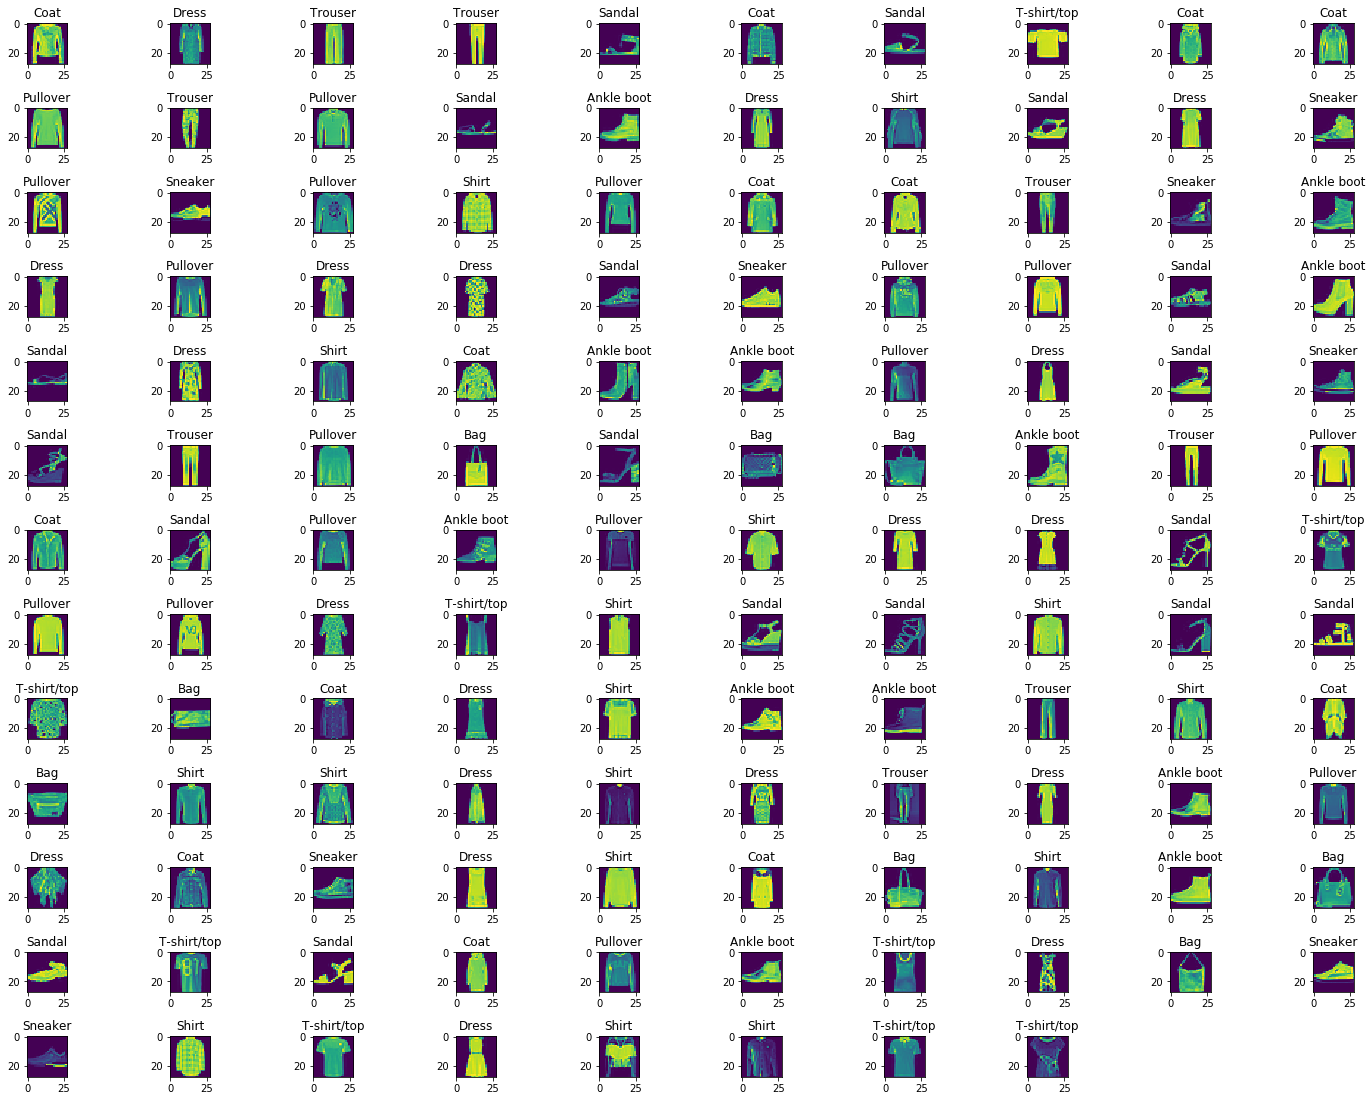

In [5]:
images, labels = next(iter(trainset))

cols = 10
f = plt.figure(figsize=(20, 150))
for i, image in enumerate(images):
    ax = f.add_subplot(ceil(len(images//cols)), cols, i+1)
    plt.imshow(image.view([28, 28]).numpy())
    ax.set_title(train.classes[labels[i]])   
    
plt.tight_layout()

In [6]:
base_neurons_qnt = 128

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1*28*28, base_neurons_qnt)
        self.fc2 = nn.Linear(base_neurons_qnt, base_neurons_qnt)
        self.fc3 = nn.Linear(base_neurons_qnt, base_neurons_qnt)
        self.fc4 = nn.Linear(base_neurons_qnt, 10)
        
    def forward(self, batch):
        batch = F.relu(self.fc1(batch))
        batch = F.relu(self.fc2(batch))
        batch = F.relu(self.fc3(batch))
        batch = F.log_softmax(self.fc4(batch), dim=1)
        
        return batch

In [7]:
def evaluate_accuracy_and_loss(model, testset):
    correct = 0
    total = 0
    
    loss = 0
    batches = 0

    with torch.no_grad():
        for batch in testset:
            images, labels = batch
            output = model(images.view([-1, 28*28]).cuda())            
            for idx, i in enumerate(output):
                if torch.argmax(i) == labels[idx]:
                    correct += 1
                total += 1
            loss += F.cross_entropy(output, labels.cuda())
            batches += 1
                
    return correct/total, loss/batches

In [9]:
%%time

net = Net().cuda()
adam = optim.Adam(net.parameters(), lr=0.001)

EPOCHS = 80

train_acc = []
test_acc = []

train_loss = []
test_loss = []

for epoch in range(EPOCHS):
    for batch in trainset:
        images, labels = batch
        net.zero_grad()
        output = net(images.view(-1, 28*28).cuda())
        loss = F.cross_entropy(output, labels.cuda())
        loss.backward()
        adam.step()
        
    train_acc_, train_loss_ = evaluate_accuracy_and_loss(net, trainset)
    test_acc_, test_loss_ = evaluate_accuracy_and_loss(net, testset)
    
    train_acc.append(train_acc_)
    train_loss.append(train_loss_)
    
    test_acc.append(test_acc_)
    test_loss.append(test_loss_)
    
    print('Epoch {}: train/test acc: {:.3f}/{:.3f} train/test loss: {:.3f}/{:.3f}'.format(epoch+1, train_acc[-1], test_acc[-1], train_loss[-1], test_loss[-1]))

Epoch 1: train/test acc: 0.848/0.833 train/test loss: 0.432/0.466
Epoch 2: train/test acc: 0.868/0.853 train/test loss: 0.367/0.411
Epoch 3: train/test acc: 0.880/0.864 train/test loss: 0.325/0.383
Epoch 4: train/test acc: 0.877/0.863 train/test loss: 0.327/0.387
Epoch 5: train/test acc: 0.895/0.872 train/test loss: 0.286/0.354
Epoch 6: train/test acc: 0.899/0.874 train/test loss: 0.273/0.349
Epoch 7: train/test acc: 0.901/0.877 train/test loss: 0.265/0.345
Epoch 8: train/test acc: 0.904/0.878 train/test loss: 0.255/0.340
Epoch 9: train/test acc: 0.911/0.883 train/test loss: 0.240/0.337
Epoch 10: train/test acc: 0.915/0.885 train/test loss: 0.229/0.330
Epoch 11: train/test acc: 0.915/0.884 train/test loss: 0.228/0.339
Epoch 12: train/test acc: 0.920/0.889 train/test loss: 0.213/0.333
Epoch 13: train/test acc: 0.920/0.884 train/test loss: 0.211/0.339
Epoch 14: train/test acc: 0.921/0.885 train/test loss: 0.205/0.333
Epoch 15: train/test acc: 0.923/0.886 train/test loss: 0.200/0.338
Epoc

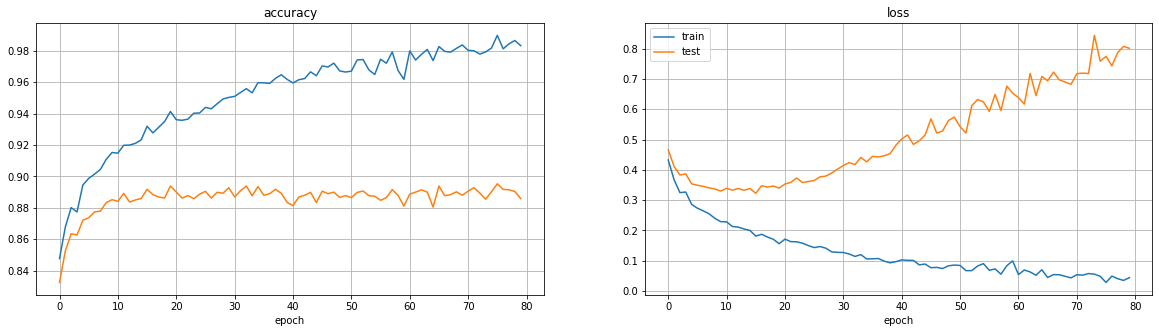

In [18]:
f = plt.figure(figsize=(20, 5))

ax = f.add_subplot(121)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
ax.set_title('accuracy')
ax.set_xlabel('epoch')
plt.grid(True)

ax = f.add_subplot(122)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
ax.set_title('loss')
ax.set_xlabel('epoch')
plt.grid(True)

plt.legend()